In [1]:
%load_ext autoreload
%autoreload 2

# ignore imputation warnings from pymc
# ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
import warnings
from pymc import ImputationWarning

warnings.filterwarnings("ignore", category=ImputationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
from birdcall_distribution.data import prepare_dataframe
import pandas as pd

taxonomy_df = pd.read_csv(
    "https://storage.googleapis.com/birdclef-eda-f22/data/raw/birdclef-2022/eBird_Taxonomy_v2021.csv"
)
taxonomy_df.columns = taxonomy_df.columns.str.lower()
species_mapper = taxonomy_df.set_index("species_code")["primary_com_name"].to_dict()

prep_df, W = prepare_dataframe(
    "../data/ee_v3_western_us_2.parquet",
    "../data/raw/birdclef-2022/train_metadata.csv",
    n_species=3,
)
prep_df.shape

(384, 33)

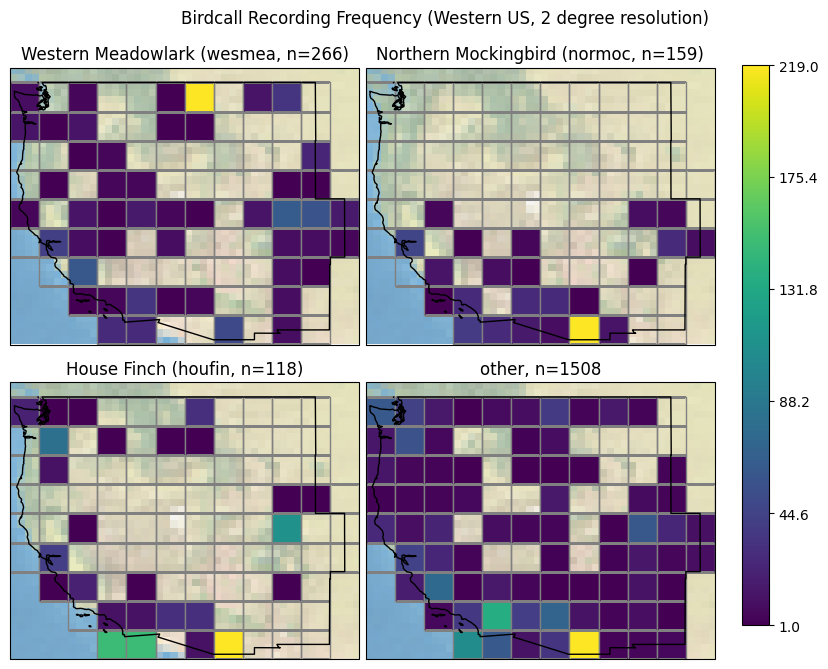

In [14]:
import matplotlib.pyplot as plt
from birdcall_distribution.plot import plot_species_subplot
import numpy as np

# grid size
grid_size = prep_df.grid_size.values[0]

# sorted list of records
species = list(
    prep_df[prep_df.primary_label != "other"]
    .groupby("primary_label")
    .sum(numeric_only=True)
    .y.sort_values(ascending=False)
    .index
)
plot_species_subplot(
    prep_df,
    species + ["other"],
    prop="y",
    subtitle=f"Western US, {grid_size} degree resolution",
    species_mapper=species_mapper,
)
plt.show()

In [4]:
from birdcall_distribution import model
import pymc as pm
import arviz as az

m1 = model.make_varying_intercept_varying_covariate_car_model(prep_df, W)
with m1:
    trace1 = pm.sample(2500, tune=1000, cores=16, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [alpha, sigma_phi, phi, intercept_bar, intercept_sigma, intercept, betas_bar, betas_sigma, betas]


Sampling 16 chains for 1_000 tune and 2_500 draw iterations (16_000 + 40_000 draws total) took 336 seconds.


Sampling: [y]


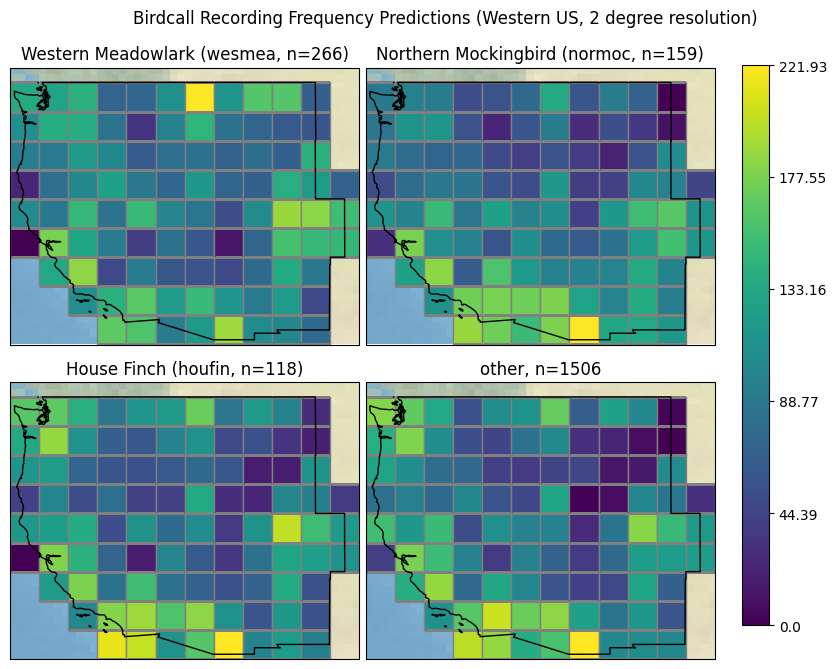

In [15]:
from birdcall_distribution.plot import plot_ppc_species_subplot

with m1:
    ppc1 = pm.sample_posterior_predictive(trace1)

plot_ppc_species_subplot(
    prep_df,
    ppc1,
    species + ["other"],
    prop="pred",
    species_mapper=species_mapper,
    subtitle=f"Western US, {grid_size} degree resolution",
)
plt.show()

In [9]:
from birdcall_distribution.geo import get_modis_land_cover_name
from birdcall_distribution.model import _scaled_data
import re


def maybe_landcover(name):
    try:
        return f"landcover {get_modis_land_cover_name(name)}".lower().replace(" ", "_")
    except Exception:
        return name


def replace_indices(name, species_list, covariate_list):
    # extract the indexes from the name e.g. [1, 2]
    [(species, covariate)] = list(re.findall(r"\[(\d+), (\d+)\]", name))
    species = species_list[int(species)]
    covariate = covariate_list[int(covariate)]
    return name.split("[")[0] + f"[{species}, {covariate}]"


scaled_df = _scaled_data(prep_df)
columns = [maybe_landcover(c) for c in scaled_df.columns]

betas = az.summary(trace1, var_names=["betas"])
sig_betas = betas[
    ((betas["hdi_3%"] > 0) & (betas["hdi_97%"] > 0))
    | ((betas["hdi_3%"] < 0) & (betas["hdi_97%"] < 0))
]
sig_betas.index = sig_betas.reset_index()["index"].apply(
    lambda x: replace_indices(
        x, prep_df.primary_label.astype("category").cat.categories, columns
    )
)
sig_betas

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
index,,,,,,,,,
"betas[houfin, population_density]",0.484,0.214,0.092,0.892,0.001,0.001,30037.0,24324.0,1.0
"betas[normoc, population_density]",0.454,0.211,0.063,0.857,0.001,0.001,25841.0,24660.0,1.0
"betas[normoc, elevation_p5]",0.543,0.238,0.089,0.981,0.001,0.001,26377.0,25876.0,1.0
"betas[normoc, LST_Day_1km_p5]",0.509,0.236,0.080,0.966,0.001,0.001,29874.0,24714.0,1.0
"betas[normoc, LST_Day_1km_p50]",0.483,0.241,0.029,0.937,0.001,0.001,37227.0,26883.0,1.0
"betas[other, landcover_urban_and_built-up]",0.388,0.197,0.038,0.774,0.001,0.001,18301.0,20622.0,1.0
"betas[other, landcover_permanent_snow_and_ice]",0.262,0.129,0.021,0.506,0.001,0.001,20001.0,25496.0,1.0
"betas[other, landcover_water_bodies]",0.302,0.148,0.023,0.580,0.001,0.001,25422.0,27462.0,1.0


In [17]:
print(sig_betas.iloc[:, :4].to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &   mean &     sd &  hdi\_3\% &  hdi\_97\% \\
index                                          &        &        &         &          \\
\midrule
betas[houfin, population\_density]              &  0.484 &  0.214 &   0.092 &    0.892 \\
betas[normoc, population\_density]              &  0.454 &  0.211 &   0.063 &    0.857 \\
betas[normoc, elevation\_p5]                    &  0.543 &  0.238 &   0.089 &    0.981 \\
betas[normoc, LST\_Day\_1km\_p5]                  &  0.509 &  0.236 &   0.080 &    0.966 \\
betas[normoc, LST\_Day\_1km\_p50]                 &  0.483 &  0.241 &   0.029 &    0.937 \\
betas[other, landcover\_urban\_and\_built-up]     &  0.388 &  0.197 &   0.038 &    0.774 \\
betas[other, landcover\_permanent\_snow\_and\_ice] &  0.262 &  0.129 &   0.021 &    0.506 \\
betas[other, landcover\_water\_bodies]           &  0.302 &  0.148 &   0.023 &    0.580 \\
\bottomrule
\end{tabular}



C:\Users\acmiy\AppData\Local\Temp\ipykernel_43208\53194228.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(sig_betas.iloc[:, :4].to_latex())


## larger number of species

In [18]:
prep_df, W = prepare_dataframe(
    "../data/ee_v3_western_us_2.parquet",
    "../data/raw/birdclef-2022/train_metadata.csv",
    n_species=15,
)
prep_df.shape

(1536, 33)

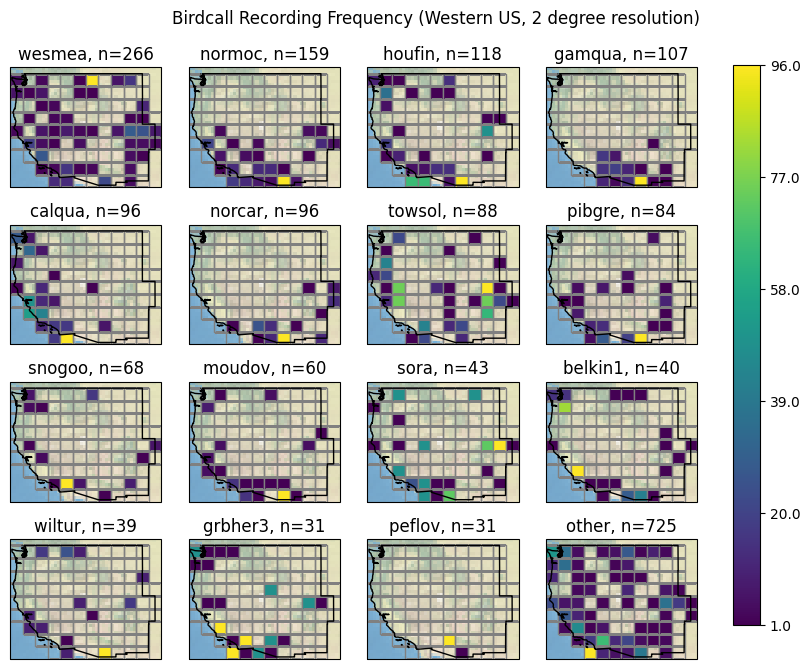

In [19]:
# grid size
grid_size = prep_df.grid_size.values[0]

# sorted list of records
species = list(
    prep_df[prep_df.primary_label != "other"]
    .groupby("primary_label")
    .sum(numeric_only=True)
    .y.sort_values(ascending=False)
    .index
)
plot_species_subplot(
    prep_df,
    species + ["other"],
    prop="y",
    subtitle=f"Western US, {grid_size} degree resolution",
    shape=(4, 4),
)
plt.show()

In [20]:
m2 = model.make_varying_intercept_varying_covariate_car_model(prep_df, W)
with m2:
    trace2 = pm.sample(2500, tune=1000, cores=16, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [alpha, sigma_phi, phi, intercept_bar, intercept_sigma, intercept, betas_bar, betas_sigma, betas]


Sampling 16 chains for 1_000 tune and 2_500 draw iterations (16_000 + 40_000 draws total) took 528 seconds.


Sampling: [y]


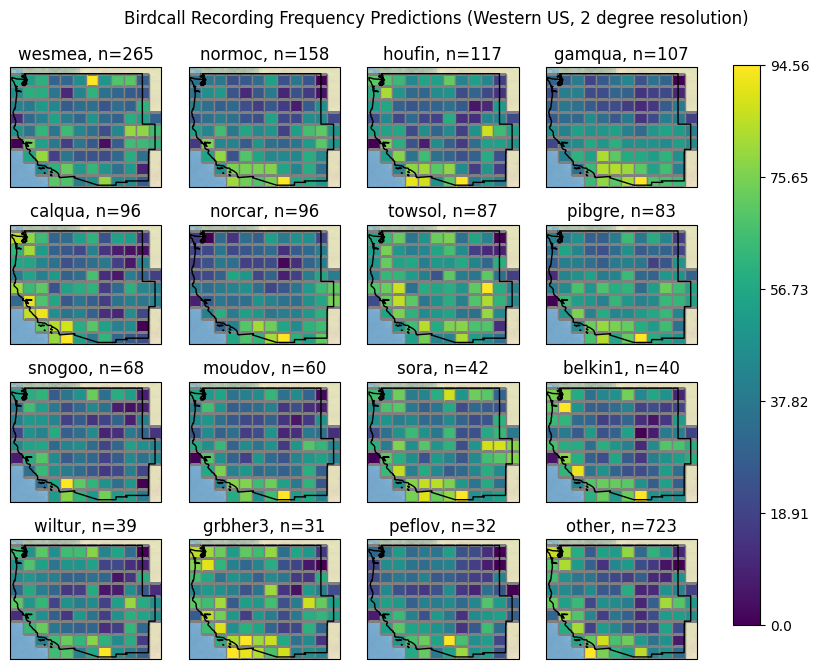

In [21]:
from birdcall_distribution.plot import plot_ppc_species_subplot

with m2:
    # posterior predictive
    ppc2 = pm.sample_posterior_predictive(trace2)

plot_ppc_species_subplot(
    prep_df,
    ppc2,
    species + ["other"],
    prop="pred",
    shape=(4, 4),
    subtitle=f"Western US, {grid_size} degree resolution",
)
plt.show()

array([[<AxesSubplot:title={'center':'betas'}>,
        <AxesSubplot:title={'center':'betas'}>],
       [<AxesSubplot:title={'center':'phi'}>,
        <AxesSubplot:title={'center':'phi'}>]], dtype=object)

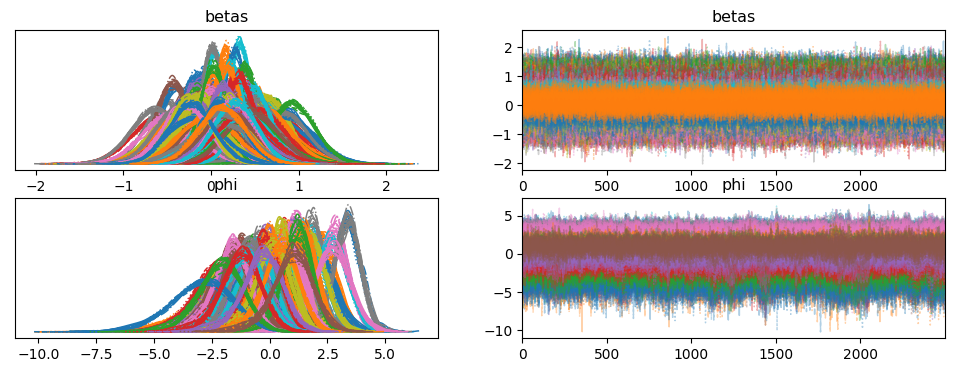

In [32]:
az.plot_trace(trace2, var_names=["betas", "phi"])

In [25]:
betas = az.summary(trace2, var_names=["betas"])
sig_betas = betas[
    ((betas["hdi_3%"] > 0) & (betas["hdi_97%"] > 0))
    | ((betas["hdi_3%"] < 0) & (betas["hdi_97%"] < 0))
]

columns = [maybe_landcover(c) for c in scaled_df.columns]

sig_betas.index = sig_betas.reset_index()["index"].apply(
    lambda x: replace_indices(
        x, prep_df.primary_label.astype("category").cat.categories, columns
    )
)
sig_betas

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
index,,,,,,,,,
"betas[calqua, LST_Day_1km_p95]",0.753,0.310,0.175,1.342,0.002,0.001,42605.0,29679.0,1.0
"betas[calqua, landcover_evergreen_broadleaf_forest]",0.593,0.230,0.161,1.024,0.001,0.001,39327.0,29997.0,1.0
"betas[calqua, landcover_closed_shrublands]",0.679,0.229,0.250,1.104,0.001,0.001,45668.0,31289.0,1.0
"betas[calqua, landcover_permanent_snow_and_ice]",0.482,0.202,0.112,0.876,0.001,0.001,36736.0,32160.0,1.0
"betas[calqua, landcover_water_bodies]",0.659,0.270,0.150,1.164,0.001,0.001,58554.0,31726.0,1.0
"betas[gamqua, landcover_open_shrublands]",0.609,0.319,0.001,1.198,0.001,0.001,57408.0,30606.0,1.0
"betas[grbher3, landcover_water_bodies]",0.636,0.274,0.124,1.149,0.001,0.001,47883.0,31536.0,1.0
"betas[houfin, population_density]",0.674,0.275,0.163,1.196,0.001,0.001,47429.0,29976.0,1.0
"betas[moudov, landcover_evergreen_needleleaf_forest]",0.547,0.287,0.021,1.100,0.001,0.001,55411.0,30155.0,1.0


In [27]:
print(sig_betas[sig_betas.index.str.contains("other")].iloc[:, :4].to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &   mean &     sd &  hdi\_3\% &  hdi\_97\% \\
index                                              &        &        &         &          \\
\midrule
betas[other, landcover\_evergreen\_broadleaf\_forest] &  0.371 &  0.156 &   0.083 &    0.668 \\
betas[other, landcover\_mixed\_forests]              & -0.391 &  0.195 &  -0.756 &   -0.026 \\
betas[other, landcover\_grasslands]                 & -0.440 &  0.186 &  -0.797 &   -0.092 \\
betas[other, landcover\_urban\_and\_built-up]         &  0.664 &  0.228 &   0.239 &    1.094 \\
betas[other, landcover\_cropland/natural\_vegetat... &  0.330 &  0.125 &   0.088 &    0.559 \\
betas[other, landcover\_permanent\_snow\_and\_ice]     &  0.274 &  0.132 &   0.029 &    0.526 \\
betas[other, landcover\_water\_bodies]               &  0.385 &  0.159 &   0.079 &    0.674 \\
\bottomrule
\end{tabular}



C:\Users\acmiy\AppData\Local\Temp\ipykernel_43208\2319693386.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(sig_betas[sig_betas.index.str.contains("other")].iloc[:, :4].to_latex())
